**Perform downstream analysis of the GEX outputs from Cell Ranger ARC**


**Cell Ranger ARC command used to generate the input GEX data:**
- Used Cellranger Arc 2.0.2 for data processing

```bash
cellranger-arc count --jobmode=local \  
    --localcores=32 \  
    --localmem=115 \  
    --id=${SAMPLE} \  
    --reference=/cellranger/refdata-cellranger-arc-GRCm39-2020-GL-2.0.2 \  
    --libraries=/cellranger/GLDS_Datasets/${STUDY}/metadata/${SAMPLE}_info.csv   
```

## Use Scanpy for filtering, normalization, and clustering
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

### Download data and set variables:

update: harcdoced input file:

In [64]:
results_file="./OSD402_scanpy_scoreCT_results.h5ad"

### Import libraries

In [10]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

### Import data

#### Extract STARsolo data

update: hardcoded input

In [69]:
adata = sc.read_10x_mtx("./",var_names='gene_symbols',cache=True)

... reading from cache file cache\matrix.h5ad


In [70]:
adata

AnnData object with n_obs × n_vars = 8267 × 56748
    var: 'gene_ids', 'feature_types'

### Preprocessing

#### Plot highest expressed genes

Show those genes that yield the highest fraction of counts in each single cell, across all cells:

normalizing counts per cell
    finished (0:00:00)


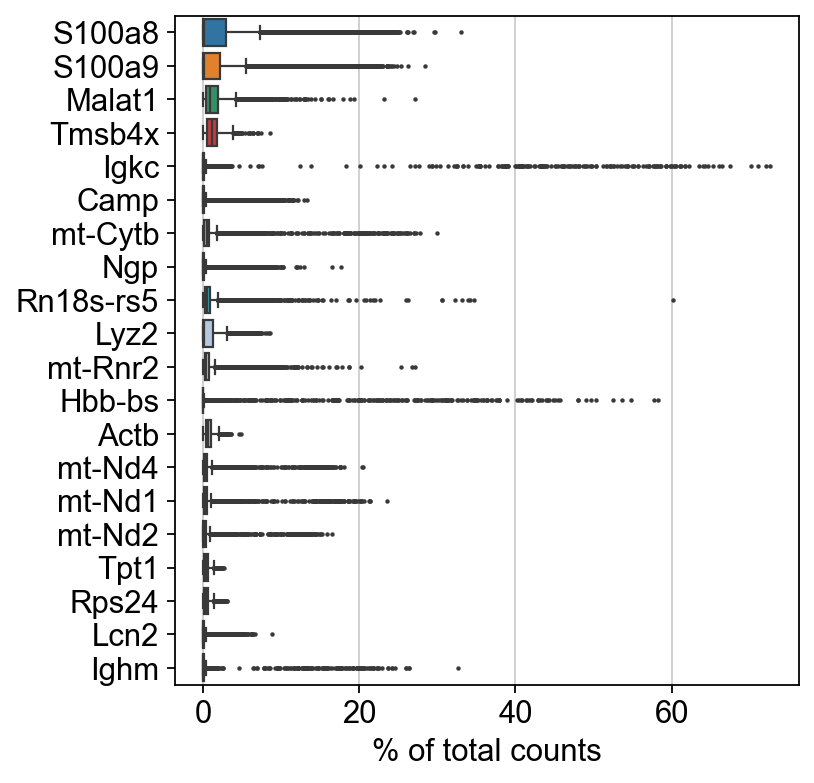

In [71]:
sc.pl.highest_expr_genes(adata, n_top=20, )

#### Basic filtering

In [72]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 155 cells that have less than 200 genes expressed
filtered out 36819 genes that are detected in less than 3 cells


#### Annotate mitochondrial genes

Identify the prefix used for mitochondrial genes:

In [73]:
# Check for common mitochondrial gene prefixes in the first 50 gene names
mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]

# Find which prefix is used in your data
for prefix in mitochondrial_prefixes:
    mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
    if mt_genes:
        print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
        print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
        break
else:
    print("No common mitochondrial gene prefix found in the first 50 gene names.")

Prefix "mt-" found with 37 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']


In [74]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

#### Plot cell QC metrics
Create violin plots of the following QC metrics:
- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

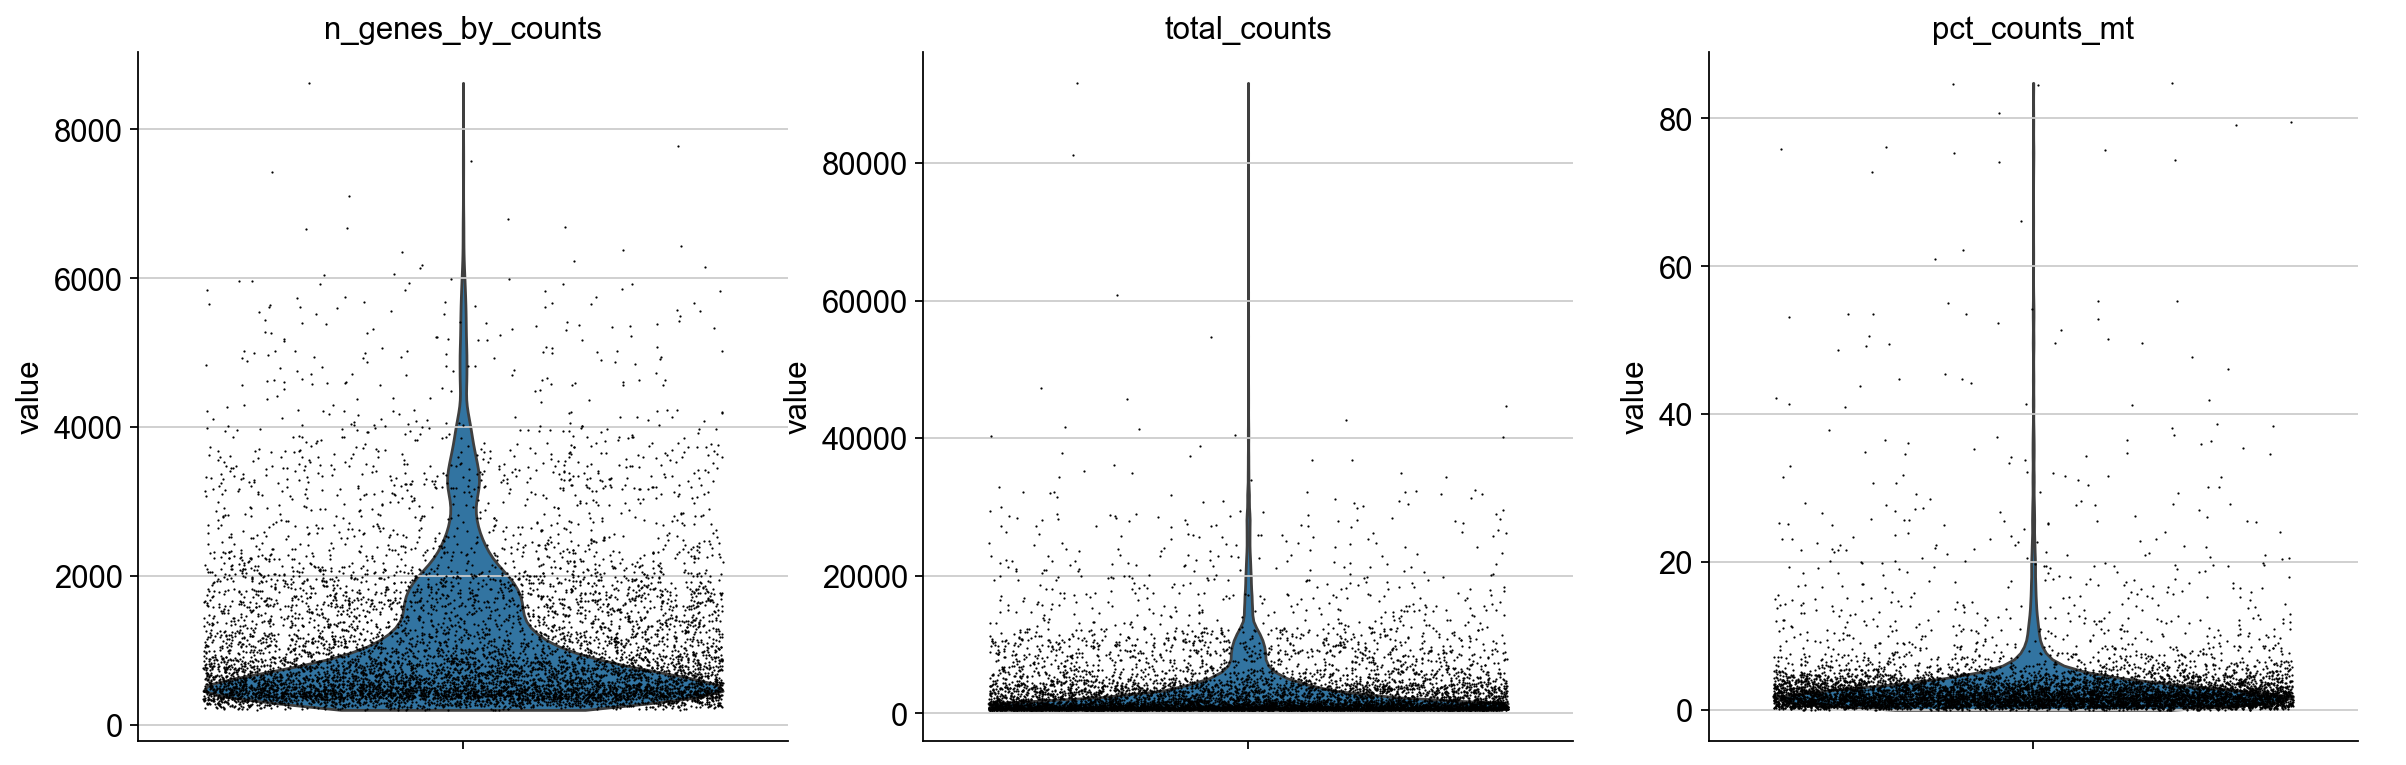

In [75]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Create scatter plots of the following:
- percent mitochondrial counts
- number of genes vs total counts

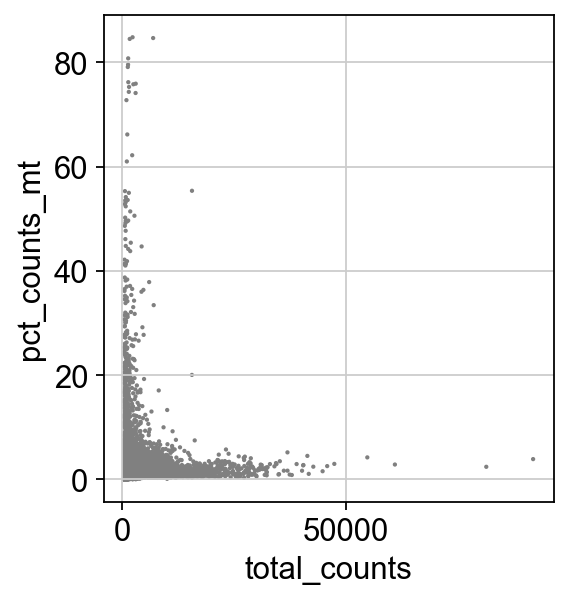

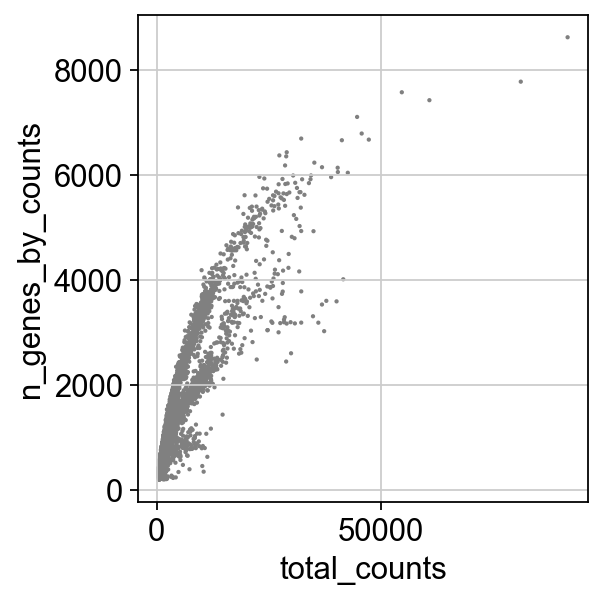

In [76]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

#### Filter cells based on gene counts and percent mt genes
Remove cells that have too many mitochondrial genes expressed or too many total counts:

In [77]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

#### Read-depth normalization
To correct for library size, normalize the count data to 10,000 reads per cell so that counts will be comparable across cells.

In [78]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Perform log-transformation

In [79]:
sc.pp.log1p(adata)

#### Plot gene QC metrics
Identify highly-variable genes:

In [80]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Plot gene expression vs dispersion:

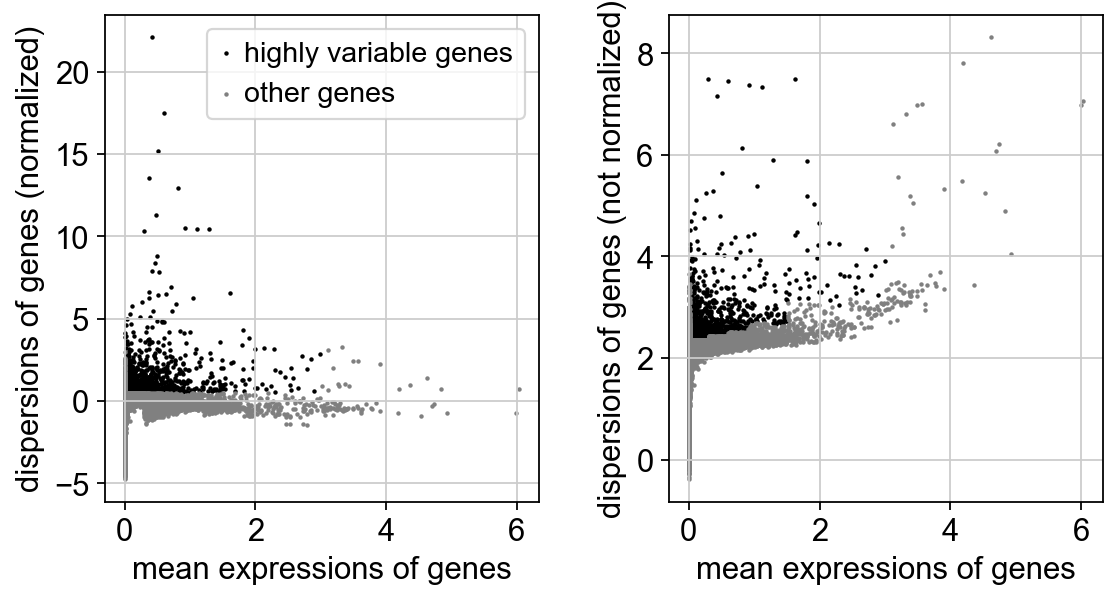

In [81]:
sc.pl.highly_variable_genes(adata)

#### Freeze the current state of the AnnData object that contains the normalized and logarithmized raw gene expression
These data will be used in downstream differential gene expression analysis and visualizations.  
*Note: The `AnnData` of the object in `.raw` can be retrieved by calling `.raw.to_adata()`*

In [82]:
adata.raw = adata

#### Filter highly-variable genes

In [83]:
adata = adata[:, adata.var.highly_variable]

#### Perform gene variance normalization
Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
This step is normalizing for read depth per cell and for the percent mitochondrial genes per cell.

In [84]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:24)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [85]:
sc.pp.scale(adata, max_value=10)

### Principal component analysis

#### Dimensionality Reduction

Calculate principal components:

In [86]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:05)


#### PCA Plots

Plot PCA coordinates:  
*Note: For scRNAseq data, PCA is to usually used, UMAP is used instead.*

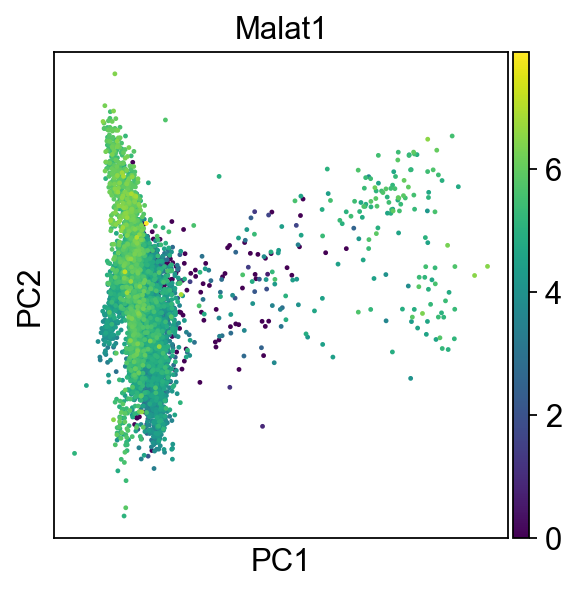

In [87]:
# colored based on expression of the most highly expressed gene identified above
# change the gene name based on your data
sc.pl.pca(adata, color="Malat1")

Plot the contribution of single PCs to the total variance in the data:  
*This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells.*

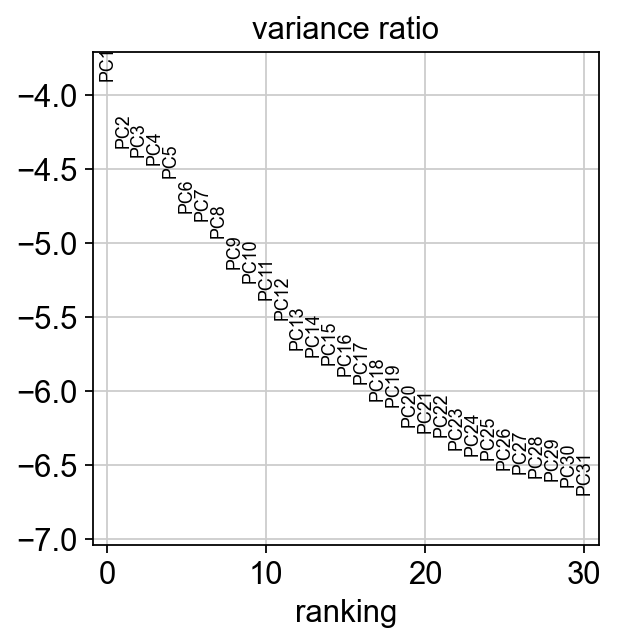

In [88]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result:

In [89]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 6427 × 2735
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute, cluster, and embed the neighborhood graph
Compute the neighborhood graph of cells using the PCA representation of the data matrix:  
*Note: The default values are used here.*

In [90]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


Embed the graph in two dimensions using UMAP (McInnes et al., 2018):

In [91]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


Print out some genes in your object to use for color-coding your UMAP:

In [92]:
# Print the first few gene names to see their format
print(adata.var_names[:20])

Index(['Gmppa', 'Rbm8a2', 'Nifk', 'Gm37490', 'Gm8251', 'Gm37106', 'Gm37463',
       '1700025G04Rik', 'Tsen15', 'Ercc5', '4833412K13Rik', 'Rgl1', 'Acsl3',
       'Smyd3', 'Sccpdh', 'Serpine2', 'Gm38009', 'Npl', 'Rgs16', 'Cavin2'],
      dtype='object')


normalizing counts per cell
    finished (0:00:00)


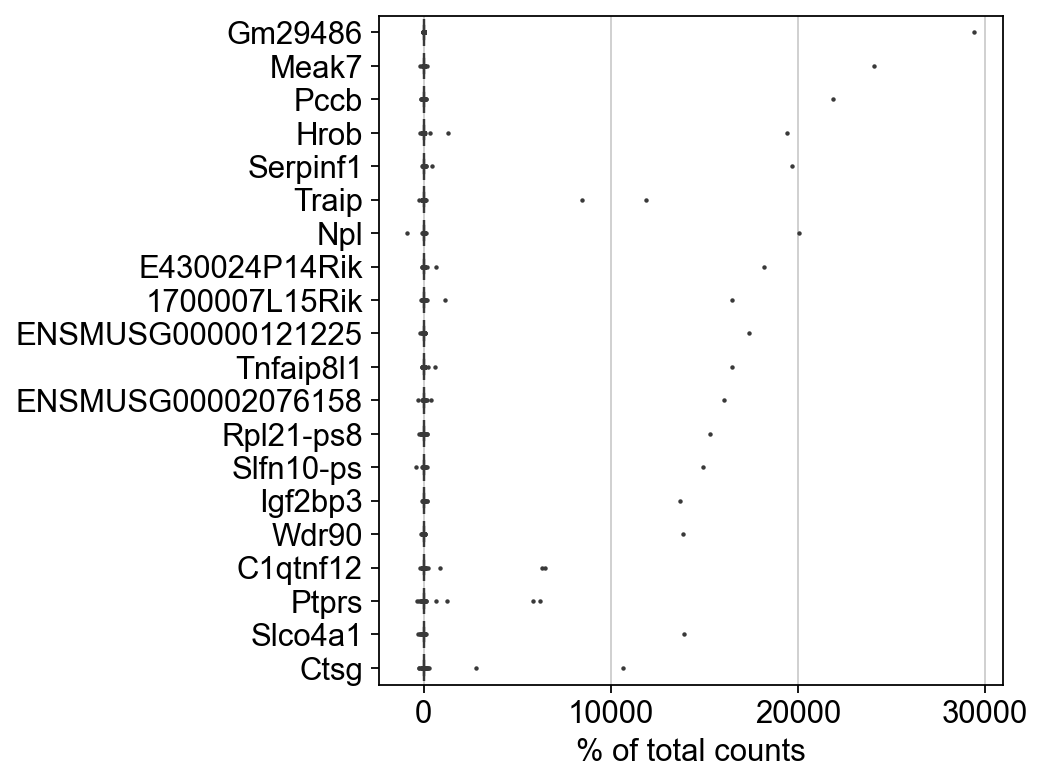

In [93]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells, after filtering
sc.pl.highest_expr_genes(adata, n_top=20, )

Plot the "raw" (normalized, logarithmized but uncorrected) gene expression UMAP for your 4 most highly expressed genes identified above:

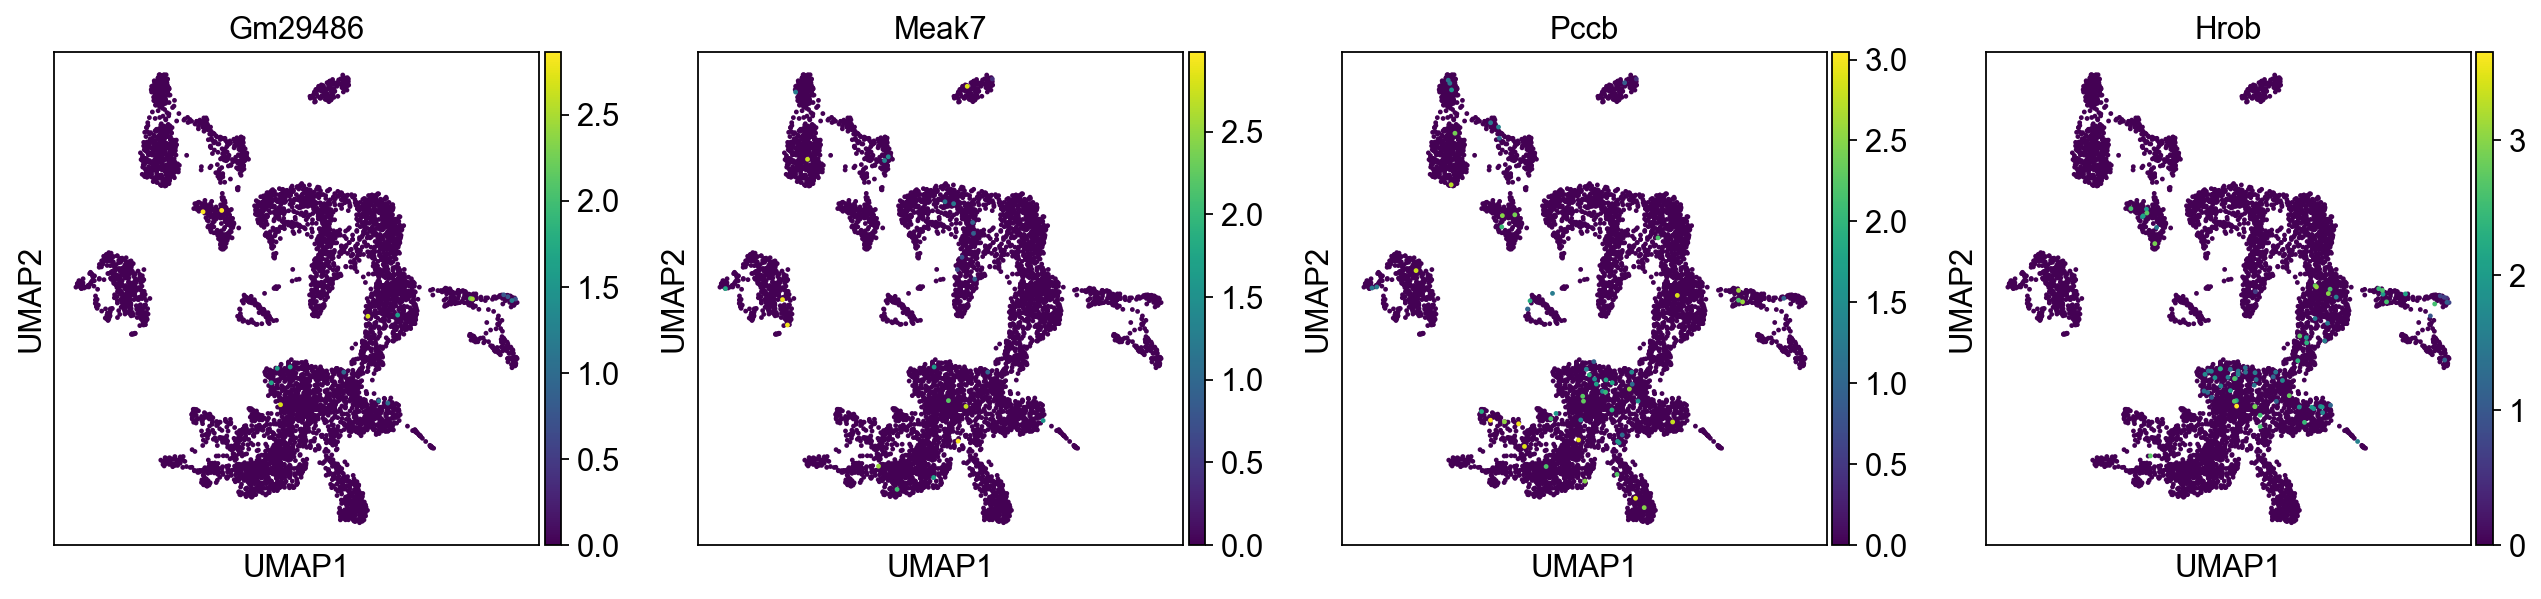

In [94]:
# change the gene names based on your data
sc.pl.umap(adata, color=["Gm29486", "Meak7", "Pccb", "Hrob"])

Plot the scaled and corrected gene expression UMAP for your 4 most highly expressed genes identified above:

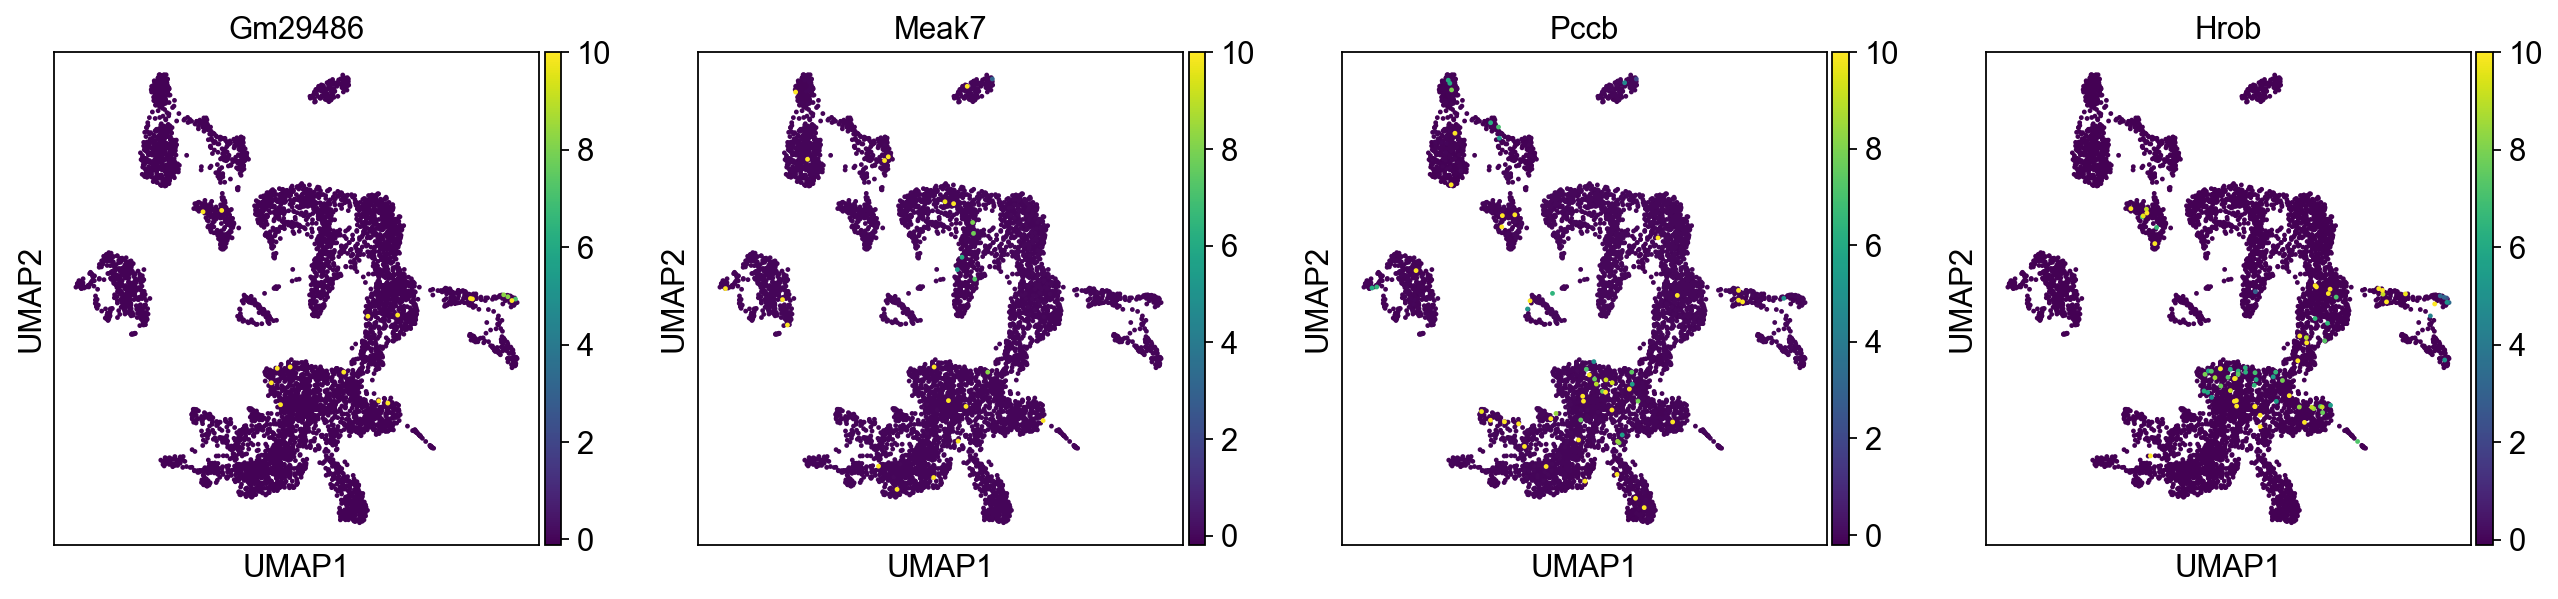

In [95]:
# change the gene names based on your data
sc.pl.umap(adata, color=["Gm29486", "Meak7", "Pccb", "Hrob"], use_raw=False)

Cluster the neighborhood graph using the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag et al. (2018):  
*See the [scanpy documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html) for how to specify clustering parameters*

In [96]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the "raw" (normalized, logarithmized, but uncorrected) gene expression UMAP with leiden clustering:

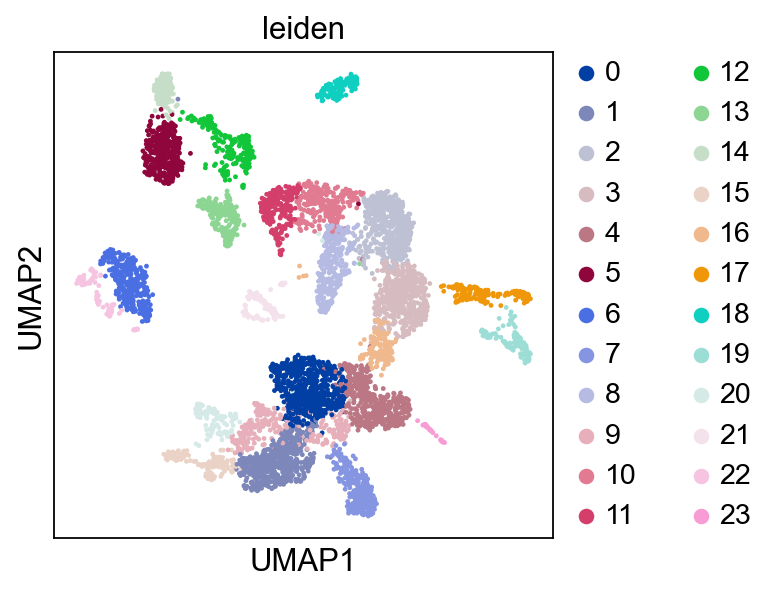

In [97]:
sc.pl.umap(adata, color=["leiden"])

Plot the scaled and corrected gene expression UMAP with leiden clustering:

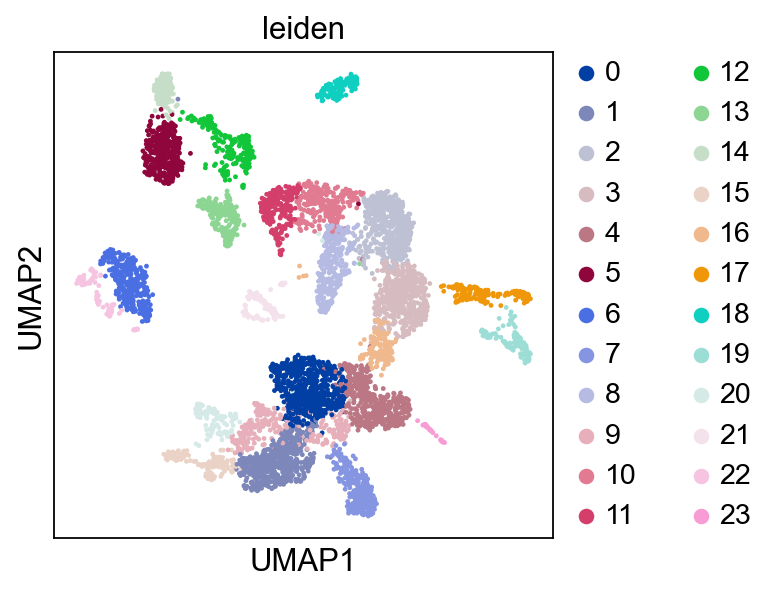

In [98]:
sc.pl.umap(adata, color=["leiden"], use_raw=False)

Save the result:

In [99]:
adata.write(results_file)

### Perform differential expression analysis between all clusters 

Compute a ranking for the highly differential genes in each cluster using the [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test:  
*Note: You can use other differential testing algorithms for the ranking.*  
*To use the t-test, replace "wilcoxon" with "t-test".*

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)


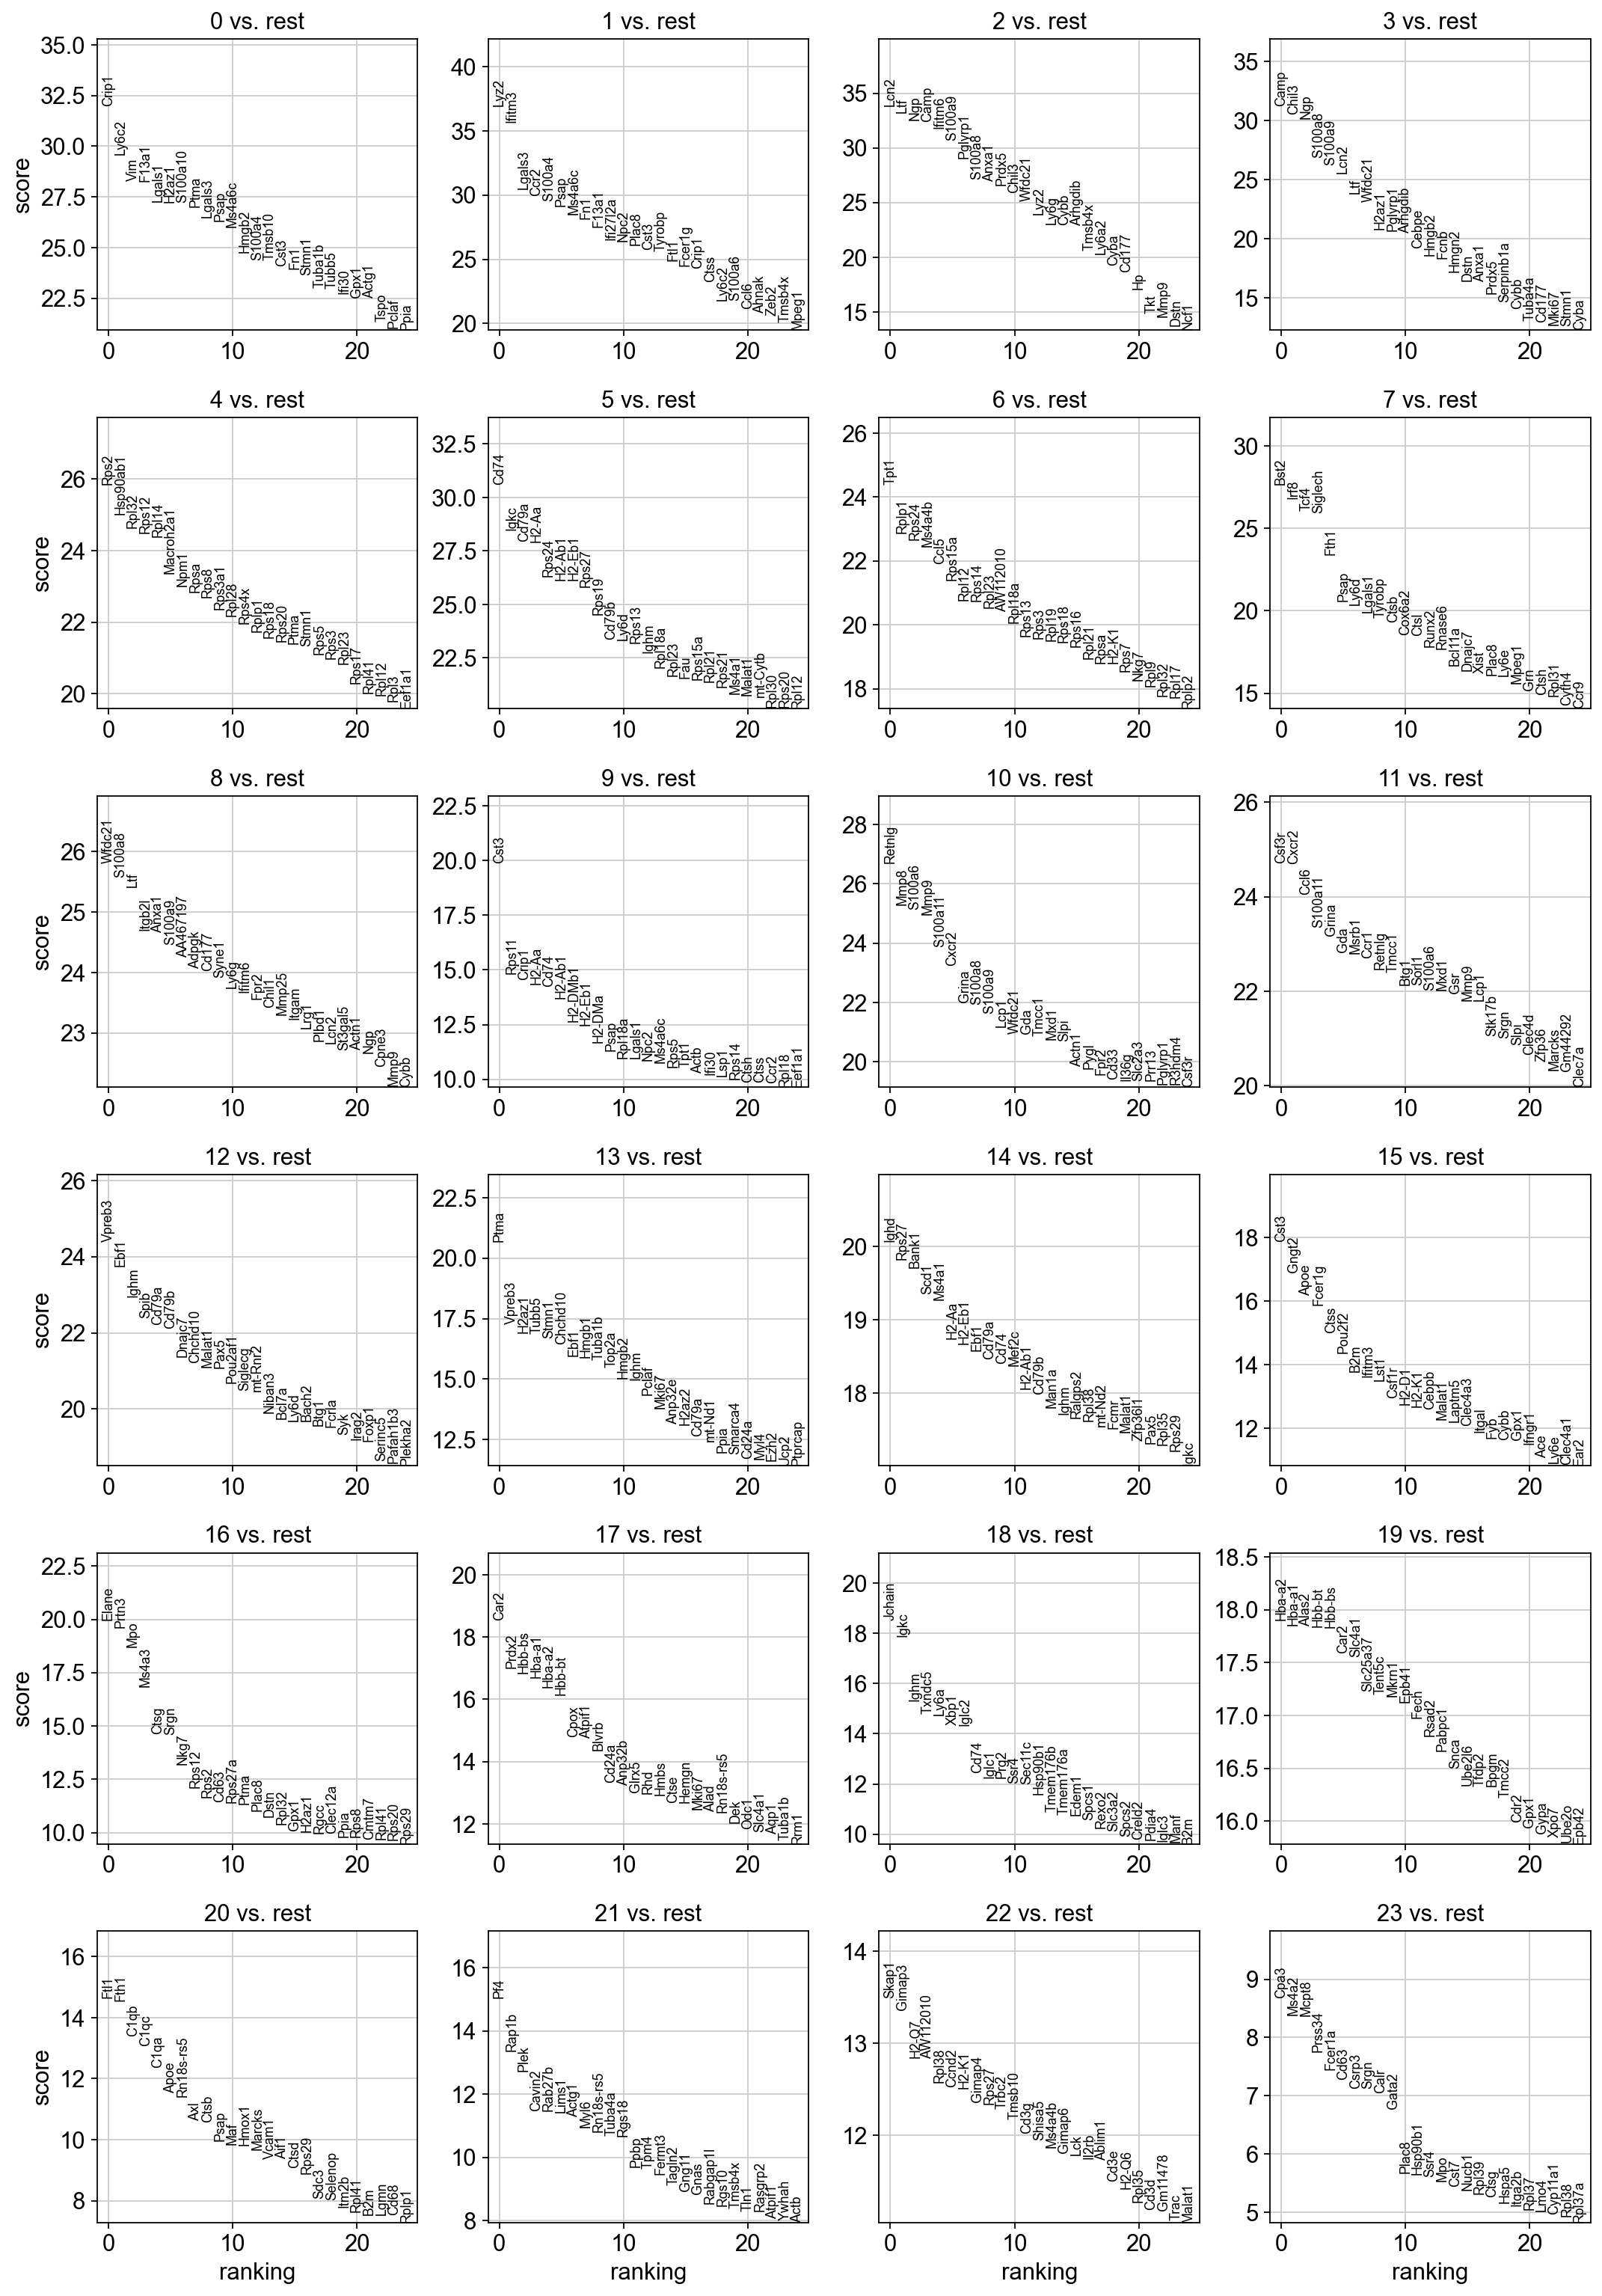

In [100]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result:

In [101]:
adata.write(results_file)

## Use scoreCT for cell type annotation
https://github.com/LucasESBS/scoreCT/blob/master/example/tuto_scoreCT.ipynb  

*Note: A forked scoreCT is required: https://github.com/asaravia-butler/scoreCT* 
> This fork replaced pd df append with pd.concat in the wrangle_ranks_from_anndata() function.

scoreCT divides the top *K* genes of each cluster ranked DE genes into *m* bins and computed a weighted score *S* for each cluster/cell type pair. A p-value is derived from 2 possible models:

* A permutation test, akin to enrichment tests (comparing *S* to random scores)
  > This is recommended if using a large number of marker genes and is used below.
* A multinomial sum approximation

The multinomial sum approximation is very fast in comparison to the permutation test, but does not approximate the results well when the number of marker genes *n* is too large compared to the total number of genes *N*. By default, scoreCT will run the multinomial sum approximation, but will automatically switch to the permutation test if *n*/*N* > 0.01.

### Import libraries and data

In [1]:
#Import modules
import os
import sys
import pandas as pd
import scanpy as sc
import scorect as ct
# Ignore warnings in this tutorial
import warnings
warnings.filterwarnings('ignore')

# Load adata object from scanpy analysis, if not already loaded
#saved_results_file = cr_data + '/' + sample + '_scanpy_scoreCT_results.h5ad'
#adata = sc.read(saved_results_file)

Import marker gene csv file:  
*Here we are using the [GeneLab marker gene](https://github.com/nasa/GeneLab_Data_Processing/tree/master/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Files) csv file for the tissue of origin.*

##Format marker_file table:

In [ ]:
import pandas as pd

In [3]:
#Load inputs:
df_input='GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers.csv'
df_output='GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.csv'

column_name='cellName'
column_gene='geneSymbol'

In [6]:
#load_data:
df = pd.read_csv(df_input)
df = pd.DataFrame(df)
#Select only cellName and geneSymbol:
df_selected = df[[column_name, column_gene]]
#Create new column for each representing gene:
df_split = df_selected[column_gene].str.split(',', expand=True)
# Concatenate the "one" column with the newly split columns
df_result = pd.concat([df[[column_name]], df[column_gene].str.split(',', expand=True)], axis=1).to_numpy()
#save results:
pd.DataFrame(df_result).to_csv(df_output, header=False, index=False)

#### Use scoreCT to assign cell types
*Note: In the command below we are using the default values for the number top genes, *K*, and the number of bins, *m**

In [2]:
#load adata (if wasn't previously):
adata = sc.read("OSD402_scanpy_scoreCT_results.h5ad")

In [4]:
marker_file= df_output

Visualize the cell type assignments:

# update:
transformed marker_file format, null_model changed from "random" to "multinomial". Previous null model glitched scoreCT and run took forever

In [5]:
# Use scoreCT one line API for assignments
ct.scorect(adata,
          marker_path=marker_file,
          K_top=300,
          m_bins=5,
          null_model='multinomial',
          cluster_key='leiden')

Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  19929
Wrangling: Groups used for ranking: leiden
Scoring cell types in reference...
Assigning cell types in adata.obs['scoreCT']...


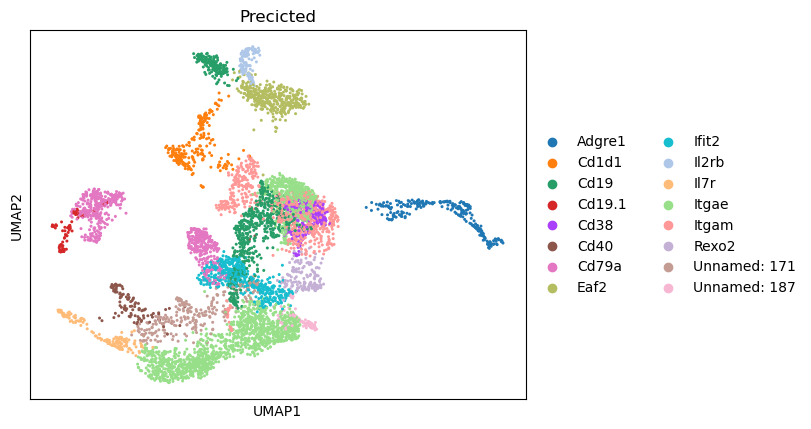

In [24]:
sc.pl.umap(adata, color=['scoreCT'], title=["Precicted"], wspace=0.33)

In [9]:
adata

AnnData object with n_obs × n_vars = 6427 × 2735
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'scoreCT'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', '_scorect', 'scoreCT_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Save the result:

In [100]:
adata.write(results_file)

# update:
umap data visualization

In [16]:
import matplotlib.pyplot as plt
sc.tl.umap(adata, n_components=3)
color = dict(zip(range(0,15), plt.cm.tab20(range(0,15))))

umap = adata.obsm["X_umap"]
umap